# Can We Predict Churn Rate?: The Lifeline of Startups and Their Customers: Modeling

In [90]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [91]:
train_csv_path = '/Users/halmorishima/Github/mycaprepo/data/train_cleaned2.csv'

# Read the CSV files into DataFrames
train_cleaned = pd.read_csv(train_csv_path)

In [92]:
train_cleaned.head()

,msno,is_churn,bd,registration_init_time,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,msno_count,city_agg_4.0,...,payment_method_id_agg_40.0,payment_method_id_agg_41.0,payment_method_id_agg_Other,is_discount,discount_amount,avg_play_time,full_play_rate,skip_tendency,repeat_tendency,membership_period
0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,20,20131223.0,30,180.0,0,0,6.0,0,...,0,0,0,0,0.0,218.328406,0.812500,0.000000,0.062500,17266
1,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,18,20131227.0,90,300.0,0,0,20.0,0,...,0,0,1,0,0.0,122.181022,0.369369,0.430631,0.221622,17331
2,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,35,20140125.0,30,99.0,1,0,15.0,0,...,0,1,0,0,0.0,243.288277,0.975659,0.009128,0.444219,17426
3,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,0,20140126.0,30,149.0,1,1,4.0,0,...,1,0,0,0,0.0,206.340102,0.755102,0.122449,0.020408,17238
4,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,28,20140202.0,410,1788.0,0,0,31.0,0,...,0,0,0,0,0.0,249.213192,0.876607,0.066838,0.350471,17663


In [93]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725722 entries, 0 to 725721
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   msno                         725722 non-null  object 
 1   is_churn                     725722 non-null  int64  
 2   bd                           725722 non-null  int64  
 3   registration_init_time       725722 non-null  float64
 4   payment_plan_days            725722 non-null  int64  
 5   actual_amount_paid           725722 non-null  float64
 6   is_auto_renew                725722 non-null  int64  
 7   is_cancel                    725722 non-null  int64  
 8   msno_count                   725722 non-null  float64
 9   city_agg_4.0                 725722 non-null  int64  
 10  city_agg_5.0                 725722 non-null  int64  
 11  city_agg_13.0                725722 non-null  int64  
 12  city_agg_15.0                725722 non-null  int64  
 13 

## Modeling

In [94]:
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

### Model Selection

For model selection, the following approach was considered:

1. **Baseline Model - Logistic Regression:**
   Begin by executing a logistic regression as the baseline model. This initial step serves as a benchmark for performance.

2. **Scalable Models - SGD Classifier and XGBoost (GBDT):**
   As the original dataset is fairly large this time, We proceed with running the SGD Classifier and XGBoost (Gradient Boosting Decision Trees). These models are capable of handling relatively larger datasets efficiently. Due to the significant data imbalance in the 'is_churn' class, consider utilizing upsampled data if needed.

3. **Decision Tree and Random Forest:**
   Following the scalable models, perform decision tree and random forest modeling. Depending on computation time, consider downsampling the data if necessary.

#### Data Split

In [95]:
# Split the train_cleaned dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    train_cleaned.drop(['is_churn', 'msno'], axis=1),
    train_cleaned['is_churn'],
    test_size=0.20,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((580577, 30), (145145, 30), (580577,), (145145,))

#### Data Scaling

In [96]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform the features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test features using the same scaler
X_test_scaled = scaler.transform(X_test)

#### Data Upsampling

In [97]:
from sklearn.utils import resample

# Separate classes
majority_class = train_cleaned[train_cleaned.is_churn == 0]
minority_class = train_cleaned[train_cleaned.is_churn == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class, 
                              replace=True, 
                              n_samples=len(majority_class), 
                              random_state=42)

# Combine the new dataset
upsampled_data = pd.concat([majority_class, minority_upsampled])

# Check the class distribution
upsampled_data.is_churn.value_counts()

0    679119
1    679119
Name: is_churn, dtype: int64

In [98]:
# Step 3: Data Splitting
X = upsampled_data.drop(['is_churn', 'msno'], axis=1)
y = upsampled_data['is_churn']

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the split data
print("Training set shape:", X_train_us.shape)
print("Test set shape:", X_test_us.shape)


Training set shape: (1086590, 30)
Test set shape: (271648, 30)


#### Data Downsampling

In [99]:
# Majority class downsampling
majority_downsampled = resample(majority_class, 
                                replace=False, 
                                n_samples=len(minority_class), 
                                random_state=42)

# Concatenate the new dataset
downsampled_data = pd.concat([majority_downsampled, minority_class])

# Check the class distribution after downsampling
downsampled_data.is_churn.value_counts()

0    46603
1    46603
Name: is_churn, dtype: int64

In [100]:
# Step 3: Data Splitting
X = downsampled_data.drop(['is_churn', 'msno'], axis=1)
y = downsampled_data['is_churn']

X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the data after splitting
print("Training set shape:", X_train_ds.shape)
print("Test set shape:", X_test_ds.shape)

Training set shape: (74564, 30)
Test set shape: (18642, 30)


### Logistics Regression(Baseline Model)

Due to the imbalance in the 'is_churn' data, running a plain logistic regression might result in the model struggling to identify one of the classes effectively. To address this concern, the following steps are proposed:

1. **Initial Run without Hyperparameter Tuning:**
   Start by running the logistic regression model in its default state without any hyperparameter tuning.

2. **Hyperparameter Tuning:**
   Proceed to fine-tune the hyperparameters of the logistic regression model. Given the challenge of overfitting due to imbalanced data, we will focus on addressing this by setting the penalty to 'l2' and performing a grid search to find an optimal regularization strength (C).

This approach aims to systematically enhance the logistic regression model's performance by considering the imbalanced class issue and optimizing the hyperparameters for better generalization.

In [101]:
# Define the logistic regression model with the optimal parameters
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predictions on the test data
y_pred = model.predict(X_test)

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Display classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.9367735712563299
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97    135968
           1       0.00      0.00      0.00      9177

    accuracy                           0.94    145145
   macro avg       0.47      0.50      0.48    145145
weighted avg       0.88      0.94      0.91    145145



/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Due to the imbalanced nature of the data, the classification is not performing well, resulting in a situation where none of the data points are being correctly identified as churn.

#### k-Fold Cross-Validation

When dealing with imbalanced class distributions, it is recommended to use stratified k-fold cross-validation. This approach ensures that the class ratios are maintained within each fold.

Since the objective is to prevent overfitting, we will use L2 regularization as the penalty, rather than L1.

In [102]:
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Define stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=5)  # Set the number of folds with the n_splits parameter

# Perform grid search and cross-validation
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=stratified_kfold, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Display the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'C': 0.1, 'penalty': 'l2'}, 0.6564680271978409)

We will use the best_params and best_score to perform logistic regression. 

In [103]:
from sklearn.metrics import precision_recall_curve, auc

# Define the logistic regression model with the best parameters
model = LogisticRegression(penalty='l2', C=best_params['C'], random_state=42, max_iter=1000)

# Train the model
model.fit(X_train_scaled, y_train)

# Predictions on the test data
y_pred = model.predict(X_test_scaled)

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
recall_score_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Display classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.9663508904888215
Recall: 0.0
F1 Score: 0.6598885793871866
ROC-AUC: 0.7565089489580624
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    135968
           1       0.91      0.52      0.66      9177

    accuracy                           0.97    145145
   macro avg       0.94      0.76      0.82    145145
weighted avg       0.96      0.97      0.96    145145



In [104]:
# Display coefficients for Logistic Regression model in descending order of influence
coefficients = model.coef_[0]
intercept = model.intercept_[0]

sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort indices by absolute coefficient values in descending order

print("Coefficients in descending order of influence:")
for index in sorted_indices:
    feature = X_train.columns[index]
    coef = coefficients[index]
    print(f"{feature}: {coef}")

print(f"Intercept: {intercept}")


Coefficients in descending order of influence:
payment_plan_days: 1.9736433823147177
is_auto_renew: -0.6538205588134377
is_cancel: 0.5705074495066044
membership_period: 0.29058935671740005
registration_init_time: -0.21272637738007666
discount_amount: 0.20373647816209695
payment_method_id_agg_Other: -0.17420849910405678
msno_count: -0.12510542340170558
registered_via_4.0: 0.09757443629735633
registered_via_9.0: -0.09213480319000811
registered_via_13.0: 0.07091278008556431
city_agg_Other: 0.0653510651768192
city_agg_5.0: 0.06113470171760278
city_agg_4.0: 0.060903250639758655
city_agg_13.0: 0.0596884467553115
city_agg_22.0: 0.050152075207727485
city_agg_15.0: 0.045553595590309824
payment_method_id_agg_38.0: -0.036212055327783314
full_play_rate: 0.035700308521255116
payment_method_id_agg_39.0: 0.03348303078680226
actual_amount_paid: 0.030776098569630116
bd: 0.030062760162928626
avg_play_time: -0.024067271958675696
is_discount: -0.018710106329219985
skip_tendency: -0.01279381905344245
payme

#### Model Validation(Logistic Regression)

To ensure that overfitting and underfitting are not occurring, we can check using the learning curve and validation curve:

Learning Curve: This curve shows how the model's performance changes with the amount of training data.

Validation Curve: This curve demonstrates how changes in hyperparameters affect the model's performance.

By examining both curves, we can gain insights into whether the model is suffering from overfitting or underfitting.

##### Learning Curve

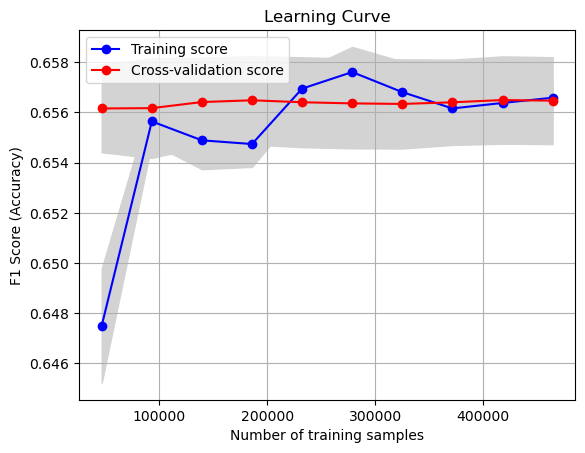

In [123]:
# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean scores and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='lightgray')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='lightgray')
plt.plot(train_sizes, train_mean, 'o-', color='b', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='r', label='Cross-validation score')
plt.xlabel('Number of training samples')
plt.ylabel('F1 Score (Accuracy)')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

While it may seem unusual that the Training Score starts from a lower point, overall, it is considered acceptable and not a major concern.

##### Validation Curve

In [106]:
# Drawing Validation Curves with Different Values of Hyperparameter 'C'
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores, test_scores = validation_curve(
    model, X_train_scaled, y_train, param_name='C', param_range=param_range,
    cv=5, scoring='f1', n_jobs=-1)

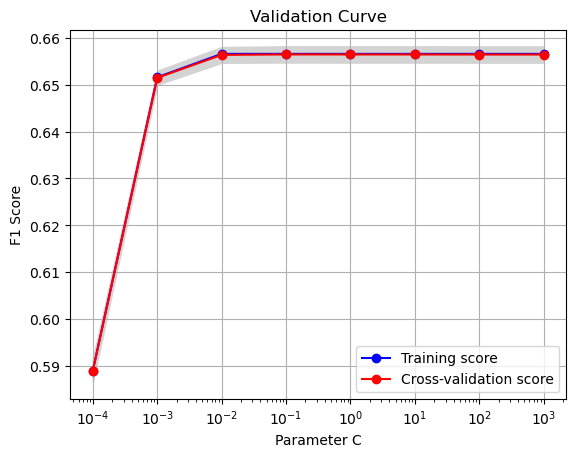

In [107]:
# Drawing Validation Curves with Different Values of Hyperparameter 'C'
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores, test_scores = validation_curve(
    model, X_train_scaled, y_train, param_name='C', param_range=param_range,
    cv=5, scoring='f1', n_jobs=-1)

# Calculating Mean Scores and Standard Deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Drawing the Validation Curve
plt.figure()
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='lightgray')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='lightgray')
plt.semilogx(param_range, train_mean, 'o-', color='b', label='Training score')
plt.semilogx(param_range, test_mean, 'o-', color='r', label='Cross-validation score')
plt.xlabel('Parameter C')
plt.ylabel('F1 Score')
plt.title('Validation Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

### SGD Classifier (Stochastic Gradient Descent Classifier)

For moderately large datasets like the one at hand, the SGD Classifier is effective due to its ability to handle substantial data volumes efficiently. It offers rapid model training while also facilitating easy regularization to control overfitting.

Due to its ability to handle relatively large datasets, we will use upsampled data for both classes in this case.

In [108]:
# Data Scaling
scaler = StandardScaler()
X_train_us_scaled = scaler.fit_transform(X_train_us)
X_test_scaled = scaler.transform(X_test)

# Defining Grid Parameters and SGD Classifier
param_grid = {
    'alpha': [0.001, 0.01],
    'learning_rate': ['optimal', 'adaptive'],
}
sgd_clf_us = SGDClassifier(random_state=42)

# Instantiating GridSearchCV
grid_search = GridSearchCV(sgd_clf_us, param_grid, cv=5, scoring='accuracy')

# Performing Grid Search (Using Upsampled Data)
grid_search.fit(X_train_us_scaled, y_train_us)

# Displaying Best Parameters and Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    self._more_validate_params()
  File "/Users/halmorishima/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py", 

Best parameters: {'alpha': 0.001, 'learning_rate': 'optimal'}
Best cross-validation score: 0.8193090310052551


In [109]:
# Training the Model with Best Parameters
best_model = grid_search.best_estimator_

# Predictions on Test Data
y_pred = best_model.predict(X_test_scaled)

# Calculating Scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Displaying Scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.897089117778773
Recall: 0.7378228179143511
F1 Score: 0.475508269251027
ROC-AUC: 0.8228307134994208
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94    135968
           1       0.35      0.74      0.48      9177

    accuracy                           0.90    145145
   macro avg       0.67      0.82      0.71    145145
weighted avg       0.94      0.90      0.91    145145



#### Model Validation(SGD Classifier)

##### Learning Curve and Validation Curve

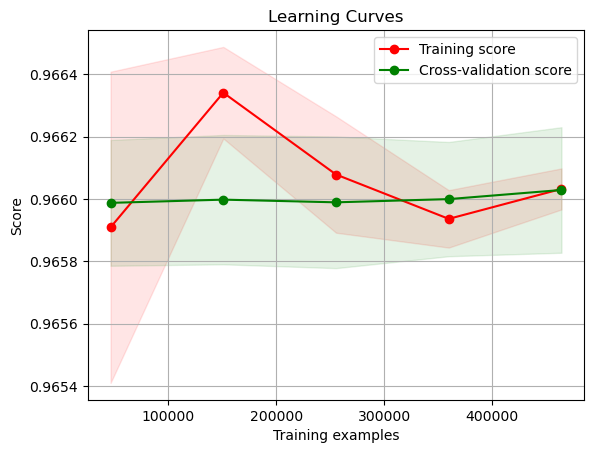

In [110]:
# Instantiating SGD Classifier
sgd_clf = SGDClassifier(alpha=0.001, learning_rate='optimal', random_state=42)

# Calculating Learning Curves
train_sizes, train_scores, test_scores = learning_curve(sgd_clf, X_train_scaled, y_train, cv=5)

# Calculating Mean Scores and Standard Deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting Learning Curves
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()


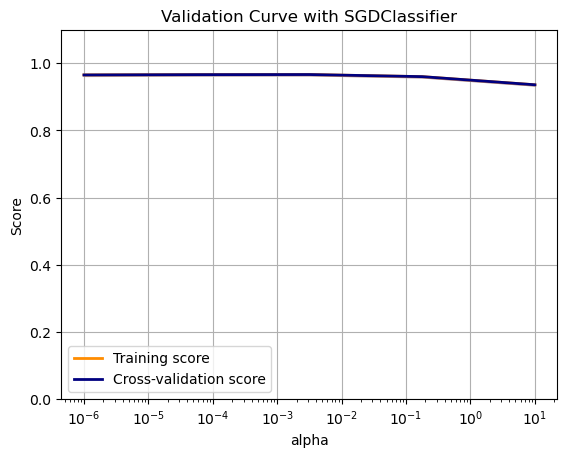

In [111]:
# Defining the Range of alpha Parameter
param_range = np.logspace(-6, 1, 5)

# Calculating Validation Curves
train_scores, test_scores = validation_curve(
    sgd_clf, X_train_scaled, y_train, param_name="alpha", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

# Calculating Mean Scores and Standard Deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting Validation Curves
plt.figure()
plt.title("Validation Curve with SGDClassifier")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.show()

### GBDT (Gradient Boosted Decision Trees) using XGBoost

To address imbalanced data, XGBoost provides the parameter scale_pos_weight, which is used to adjust the weights of classes in the model training process. This is particularly useful when dealing with situations where one class is significantly underrepresented compared to the other. 

In [112]:
# Calculate the scale_pos_weight based on class imbalance
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

# Train the XGBoost model using the calculated scale_pos_weight
xgb_clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_clf.fit(X_train_scaled, y_train)

# Make predictions using the trained model
y_pred = xgb_clf.predict(X_test_scaled)
y_pred_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display evaluation scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Display the Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.7266182093768301
Recall: 0.7414187643020596
F1 Score: 0.2553670620027023
ROC-AUC: 0.7937209614288415
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.73      0.83    135968
           1       0.15      0.74      0.26      9177

    accuracy                           0.73    145145
   macro avg       0.57      0.73      0.54    145145
weighted avg       0.92      0.73      0.80    145145



### Decision Tree

The Decision Tree algorithm operates independently of data scaling or normalization, thanks to its use of feature thresholds for data splitting, which renders it insensitive to scaling effects. As such, there is no need to scale the data when training a Decision Tree model.

When dealing with imbalanced data, we can use unbalanced data directly for training, or adjust the class_weight parameter to assign greater weight to the minority class.

In [113]:
# Define the distribution of hyperparameters
param_distributions = {
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Perform RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display the best parameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Train the model using the best parameters
dt_clf = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf.fit(X_train, y_train)

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'class_weight': 'balanced'}
Best cross-validation score: 0.9501220323419629


DecisionTreeClassifier(class_weight='balanced', max_depth=40,
                       min_samples_leaf=2, random_state=42)

In [114]:
# Model evaluation
y_pred = dt_clf.predict(X_test)
y_pred_proba = dt_clf.predict_proba(X_test)[:, 1]

# Calculate scores
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Display Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.9516621309724758
Recall: 0.7030620028331699
F1 Score: 0.6477911646586345
ROC-AUC: 0.8406641165630879
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97    135968
           1       0.60      0.70      0.65      9177

    accuracy                           0.95    145145
   macro avg       0.79      0.84      0.81    145145
weighted avg       0.96      0.95      0.95    145145



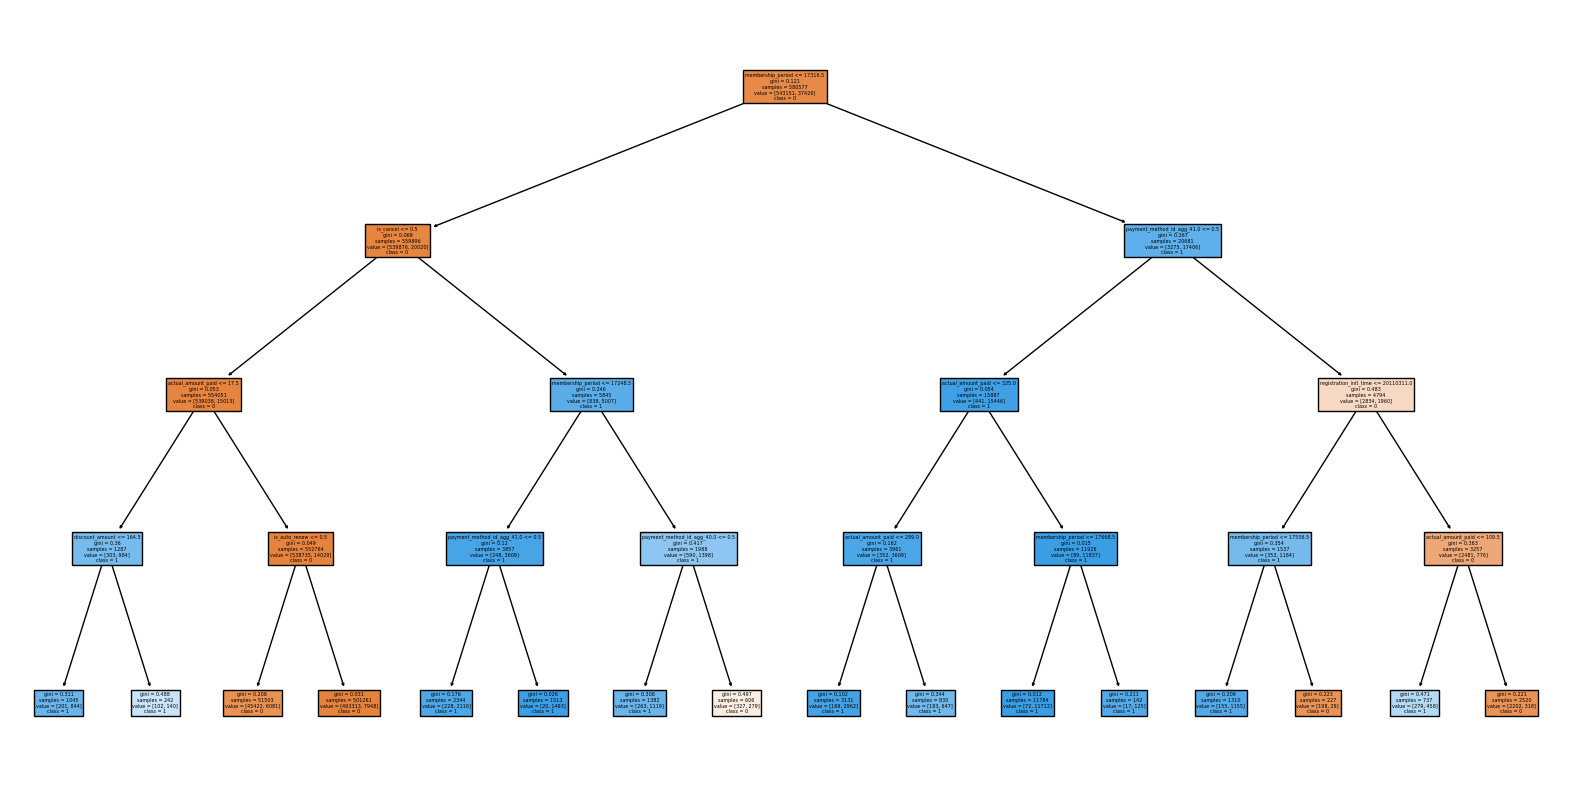

In [115]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train the decision tree model with max_depth=3
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# Visualize the decision tree with limited depth
plt.figure(figsize=(20, 10))  # Adjust the figsize as needed
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['0', '1'])  # Replace with your class labels
plt.show()

#### Model Validation(Decision Tree)

##### Learning Curve and Validation Curve

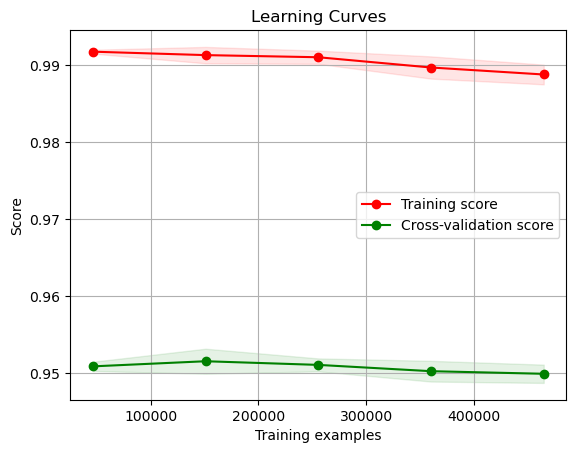

In [116]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    dt_clf, X_train, y_train, cv=5, scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()


Although there is a visual difference between the learning curve and the validation curve, the numerical disparity is not substantial. As a result, it can be deemed acceptable.

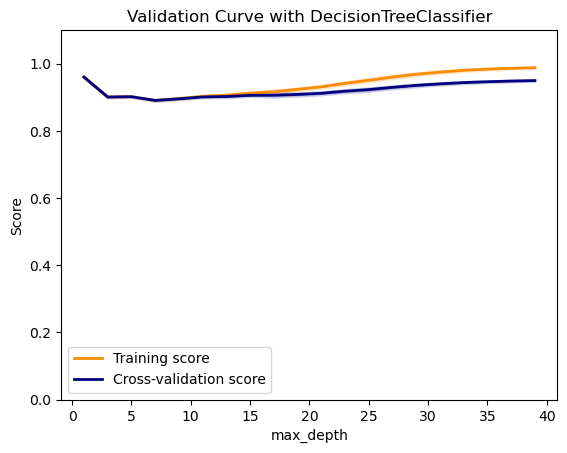

In [117]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 41, 2)
train_scores, test_scores = validation_curve(
    dt_clf, X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve with DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Random Forest Classifier

Random Forest, as compared to Decision Trees, constructs a model by combining multiple decision trees to mitigate overfitting. In this case, although overfitting isn't observed with the Decision Tree model, we aim to enhance predictive performance and will proceed to compare both models.

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the range of hyperparameters
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'], 
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_distributions, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Perform RandomizedSearchCV
random_search.fit(X_train_ds, y_train_ds)

# Display the best parameters and corresponding score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Train the model using the best parameters
rf_clf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_ds, y_train_ds)

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'class_weight': 'balanced'}
Best cross-validation score: 0.8913282895586965


RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [119]:
# Train the model using the best parameters
rf_clf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_ds, y_train_ds)

# Model evaluation
y_pred = rf_clf.predict(X_test_ds)  # Predict class labels on the test data
y_pred_proba = rf_clf.predict_proba(X_test_ds)[:, 1]  # Predict probabilities of the positive class

# Calculating scores
accuracy = accuracy_score(y_test_ds, y_pred)  # Calculate accuracy
recall = recall_score(y_test_ds, y_pred)  # Calculate recall
f1 = f1_score(y_test_ds, y_pred)  # Calculate F1 score
roc_auc = roc_auc_score(y_test_ds, y_pred_proba)  # Calculate ROC-AUC score

# Displaying scores
print(f"Accuracy: {accuracy}")  # Print accuracy
print(f"Recall: {recall}")  # Print recall
print(f"F1 Score: {f1}")  # Print F1 score
print(f"ROC-AUC: {roc_auc}")  # Print ROC-AUC score

# Displaying Classification Report
class_report = classification_report(y_test_ds, y_pred)  # Generate classification report
print('Classification Report:\n', class_report) 

Accuracy: 0.8959875549833709
Recall: 0.885956442441798
F1 Score: 0.8949336223245733
ROC-AUC: 0.9589509982966249
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      9321
           1       0.90      0.89      0.89      9321

    accuracy                           0.90     18642
   macro avg       0.90      0.90      0.90     18642
weighted avg       0.90      0.90      0.90     18642



#### Model Validation(Random Forest)

##### Learning Curve and Validation Curve

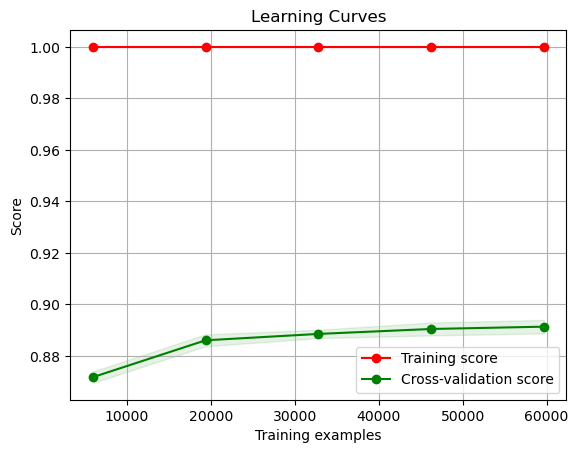

In [122]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_clf, X_train_ds, y_train_ds, cv=5, scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

The rapid increase in the training score from the beginning to 100 iterations raises concerns. Moreover, the noticeable deviation between the training and test scores cannot be disregarded, indicating a tendency towards overfitting. Due to computational limitations, we refrain from delving further into these observations. In an ideal scenario, an analysis should involve unbiased data, but for the sake of computation time, we won't pursue further investigation.

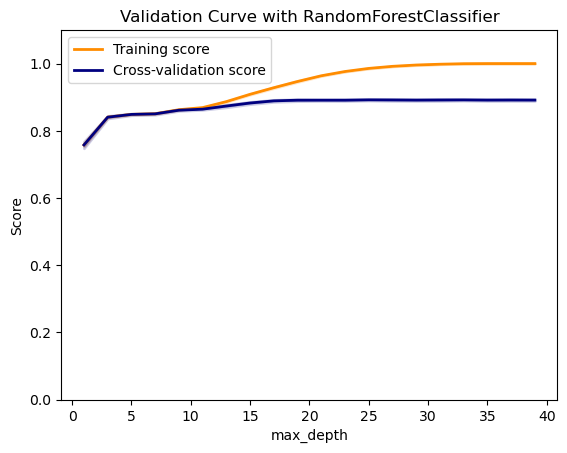

In [121]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 41, 2)
train_scores, test_scores = validation_curve(
    rf_clf, X_train_ds, y_train_ds, param_name="max_depth", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
         color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
         color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


## Model Evaluation

The choice of evaluation metrics depends on business goals and the nature of the specific problem. In the current case of churn prediction, the utility of each evaluation metric is considered as follows:

- Accuracy: Represents overall correctness, but it's less useful when dealing with imbalanced data.
- Recall: Useful when reducing false negatives is important. It's valuable when misclassifying churn customers as non-churn customers has high costs.
- F1 score: Useful for balancing Precision and Recall, suitable when considering both aspects.
- ROC-AUC: Evaluates the classifier's ability to distinguish between positive and negative classes. Particularly useful when dealing with imbalanced data or important threshold selection.

In this scenario, where churn instances are typically the minority class and predicting them is crucial for business, ROC-AUC, Recall, and F1 score are assumed to be particularly useful evaluation metrics.

| Model                 | ROC-AUC  | Recall  | F1 Score |
|-----------------------|----------|---------|----------|
| Logistic Regression   | 0.76     | 0.52    | 0.66     |
| SGD Classifier        | 0.82     | 0.74    | 0.48     |
| XGBoost               | 0.79     | 0.74    | 0.26     |
| Decision Tree         | 0.84     | 0.70    | 0.65     |
| Random Forest         | 0.96     | 0.89    | 0.89     |

When examining learning curves and validation curves for the Random Forest model, I observed signs of overfitting. Despite my initial intention to utilize unbiased unsampled data, I had to relinquish this idea due to computational time constraints.

For the Logistics Regression model, there appears to be a high F1 Score (Class 1), but the Recall values are notably low. This suggests that the model struggles to correctly classify instances of Class 1, showing some shortcomings in its performance.

A balanced approach is evident in the Decision Tree model, which boasts high ROC values, along with elevated Recall and F1 scores.

## Implication

### Coefficiency of Logistic Regression

- payment_plan_days: The likelihood of churn increases as the duration of the payment plan becomes longer. This is because customers who opt for longer-term plans are more likely to churn within that extended period, influenced by the commitment associated with such plans.

- is_auto_renew: When auto-renewal is enabled, the probability of churn decreases. Auto-renewal is a convenient feature for customers, eliminating the need for manual renewal and thereby enhancing the likelihood of continued subscription.

- is_cancel: If cancellations occur, the probability of churn rises. Cancellations can act as precursors to churn, thereby contributing to an increased likelihood of customers leaving the service.

### Decision Tree

From the decision tree analysis, it became evident that factors such as the membership period, the presence of cancellation (is_cancel), and a specific payment method (payment_method_41) are correlated with the churn rate.